In [98]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# IMPORTING DATA

column_names = ['ax', 'ay', 'az', 'gx', 'gy', 'gz','t']
fs=10
dfL = pd.read_csv('L2025-02-02-05-29-45.csv', names=column_names, header=None) # change filename to pull datetime
dfR = pd.read_csv('R2025-02-02-05-29-45.csv', names=column_names, header=None) # change filename to pull datetime

num_rowsL = dfL.shape[0]
num_rowsR = dfR.shape[0]

min_rows = min(num_rowsL, num_rowsR)

if num_rowsL > min_rows:
    dfL = dfL.iloc[-min_rows:]

if num_rowsR > min_rows:
    dfR = dfR.iloc[-min_rows:]

print(dfL.head())
print(dfR.head())

gyL_v = np.array(dfL[['gy']]).flatten()
tL_v = np.array(dfL[['t']]).flatten()

gyR_v = np.array(dfR[['gy']]).flatten()
tR_v = np.array(dfR[['t']]).flatten()

     ax    ay    az    gx    gy    gz    t
0  8.50  1.09 -4.03 -0.05  0.03  0.02  0.0
1  8.46  1.12 -4.10 -0.05  0.03  0.01  0.0
2  8.48  1.07 -3.97 -0.05  0.02  0.01  0.0
3  8.47  1.09 -4.00 -0.05  0.02  0.01  0.0
4  8.46  1.10 -4.02 -0.05  0.02  0.01  0.0
     ax    ay    az    gx    gy    gz    t
0  9.60 -0.29 -2.70  0.02 -0.03  0.02  0.0
1  9.63 -0.31 -2.70  0.02 -0.03  0.02  0.0
2  9.61 -0.26 -2.72  0.03 -0.02  0.02  0.0
3  9.62 -0.34 -2.70  0.03 -0.02  0.02  0.0
4  9.62 -0.31 -2.66  0.03 -0.01  0.02  0.0


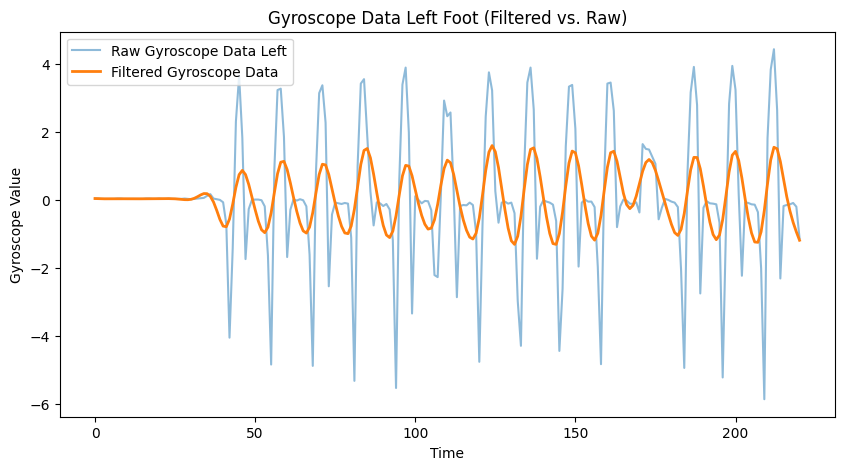

In [99]:
# CLEANING DATA

def butter_lowpass_filter(data, cutoff=5, fs=100, order=4):
    nyquist = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

gyL_v_f = butter_lowpass_filter(gyL_v, cutoff = 1, fs = fs, order=3)
gyR_v_f = butter_lowpass_filter(gyR_v, cutoff = 1, fs = fs, order=3)
plt.figure(figsize=(10, 5))
plt.plot(gyL_v, label="Raw Gyroscope Data Left", alpha=0.5)
plt.plot(gyL_v_f, label="Filtered Gyroscope Data", linewidth=2)
plt.legend()
plt.title("Gyroscope Data Left Foot (Filtered vs. Raw)")
plt.xlabel("Time")
plt.ylabel("Gyroscope Value")
plt.show()

In [100]:
# DETECTING HS AND TO POINTS

HS_IndicesL, _ = find_peaks(-gyL_v_f, prominence=0.5)
TO_IndicesL, _ = find_peaks(gyL_v_f, prominence=0.5)

minDataL = min(len(HS_IndicesL), len(TO_IndicesL))
HS_IndicesL = HS_IndicesL[:minDataL]
TO_IndicesL = TO_IndicesL[:minDataL]

HS_TimesL = tL_v[HS_IndicesL]
TO_TimesL = tL_v[TO_IndicesL]

HS_IndicesR, _ = find_peaks(-gyR_v_f, prominence=0.5)
TO_IndicesR, _ = find_peaks(gyR_v_f, prominence=0.5)

minDataR = min(len(HS_IndicesR), len(TO_IndicesR))
HS_IndicesR = HS_IndicesR[:minDataR]
TO_IndicesR = TO_IndicesR[:minDataR]

HS_TimesR = tR_v[HS_IndicesR]
TO_TimesR = tR_v[TO_IndicesR]

In [101]:
# CALCULATING BASIC GAIT PARAMETERS

strideTimesL = np.diff(HS_TimesL)
avgStrideDurationL = np.mean(strideTimesL)

strideTimesR = np.diff(HS_TimesR)
avgStrideDurationR = np.mean(strideTimesR)

avgStrideDuration = (avgStrideDurationL + avgStrideDurationR) / 2

stanceTimesL = np.abs(TO_TimesL - HS_TimesL) + (1 / fs)
avgStanceDurationL = np.mean(stanceTimesL)

stanceTimesR = np.abs(TO_TimesR - HS_TimesR) + (1 / fs)
avgStanceDurationR = np.mean(stanceTimesR)

avgStanceDuration = (avgStanceDurationL + avgStanceDurationR) / 2

minDataL = min(len(strideTimesL), len(stanceTimesL))
swingTimesL = strideTimesL[:minDataL] - stanceTimesL[:minDataL]
avgSwingDurationL = np.mean(swingTimesL)

minDataR = min(len(strideTimesR), len(stanceTimesR))
swingTimesR = strideTimesR[:minDataR] - stanceTimesR[:minDataR]
avgSwingDurationR = np.mean(swingTimesR)

avgSwingDuration = (avgSwingDurationL + avgSwingDurationR) / 2


NumStridesL = (tL_v[-1] - tL_v[0])/avgStrideDurationL;
NumStridesR = (tR_v[-1] - tR_v[0])/avgStrideDurationR;

avgNumStrides = (NumStridesR + NumStridesR) / 2;

avgCadenceL = NumStridesL/((tL_v[-1] - tL_v[0])/60);
avgCadenceR = NumStridesR/((tR_v[-1] - tR_v[0])/60);

avgCadence = (avgCadenceL + avgCadenceR) / 2
print(avgCadence)


45.013194376355095


In [102]:
# CALCULATING COMPLEX GAIT VARIABLES

SDeviationL = np.std(strideTimesL, ddof=1)
SDeviationR = np.std(strideTimesR, ddof=1)
SDeviation = (SDeviationL + SDeviationR) / 2

CoeffVariationL = (SDeviationL / np.mean(strideTimesL)) * 100
CoeffVariationR = (SDeviationR / np.mean(strideTimesR)) * 100

gaitVariability = (CoeffVariationR + CoeffVariationL) / 2

gaitAsymmetry = 100 * abs(np.log(avgSwingDurationR / avgSwingDurationL))

# ACTIVITY DETECTION

walkingSpeed = 60 # change this to be avg cadence pulled from database
walkingStrideDuration = 1 / (walkingSpeed / 60)

fastWalkingStrideDuration = 0.75 * walkingStrideDuration
runningStrideDuration = 0.5 * walkingStrideDuration

stairSpeed = 0.5 * walkingSpeed
stairStrideDuration = 1 / (stairSpeed / 60)

min_len = min(len(tL_v), len(strideTimesL))
tL_v = tL_v[:min_len]
strideTimesL = strideTimesL[:min_len]

# Initialize 2D array (object type for mixed time & string)
activity = np.empty((min_len, 2), dtype=object)

# Assign time values from 't' to the first column
activity[:, 0] = tL_v

# Assign activity labels based on stride time conditions
for i in range(min_len):
    strideTime = strideTimesL[i]
    if 0.75 * fastWalkingStrideDuration <= strideTime <= 1.25 * fastWalkingStrideDuration:
        activity[i, 1] = "Fast Walking"
    elif 0.9 * stairStrideDuration <= strideTime <= 1.1 * stairStrideDuration:
        activity[i, 1] = "Climbing/Descending Stairs"
    elif 0.75 * walkingStrideDuration <= strideTime <= 1.25 * walkingStrideDuration:
        activity[i, 1] = "Walking"
    else:
        activity[i, 1] = "Stationary"

print(activity)

# ADD PART TO OUTPUT


[[0.0 'Climbing/Descending Stairs']
 [0.0 'Climbing/Descending Stairs']
 [0.0 'Climbing/Descending Stairs']
 [0.0 'Climbing/Descending Stairs']
 [0.0 'Climbing/Descending Stairs']
 [0.0 'Climbing/Descending Stairs']
 [0.0 'Climbing/Descending Stairs']
 [0.0 'Climbing/Descending Stairs']
 [0.0 'Climbing/Descending Stairs']
 [0.0 'Stationary']
 [0.0 'Stationary']
 [0.0 'Climbing/Descending Stairs']
 [0.0 'Climbing/Descending Stairs']]
